In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from models import Models
from morph import Morph
from generation import Generation

In [2]:
shift_values = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]

final = {}
for b in [0.05, 0.10, 0.15, 0.20, 0.25]:
    results = {}
    for s in shift_values:
        # Generate dataset with shift
        gen = Generation(base_functions=('sin', 'sin'), n_samples=100, frequencies=(0.5,0.5), noise_level=(0.05, 0.05), shift_vert=s, shif_horz=s) 
        X, y = gen.generate_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train models
        lstm = Models('lstm', X_train, y_train)
        lstm.train_lstm()
        catch22 = Models('catch22', X_train, y_train)
        catch22.train_catch22()
        rocket = Models('rocket', X_train, y_train)
        rocket.train_rocket()

        # Calculate morphing
        res = {}
        morph = Morph(X_test, y_test)
        morph.get_DTWGlobalBorderline(perc_samples=b) 

        res['lsmt'] = morph.Binay_MorphingCalculater(lstm)
        res['catch22'] = morph.Binay_MorphingCalculater(catch22)
        res['rocket'] = morph.Binay_MorphingCalculater(rocket)

        results[s] = res
    final[b] = results

In [3]:
with open('results/bord_perc_shift_perf.pkl', 'wb') as f:
    pickle.dump(final, f)

In [4]:
columns = ['border_perc', 'shift_val', 'model', 'mean', 'std']

data = []
for border_perc in final.keys():
    for shift_val in final[border_perc].keys():
        for model in final[border_perc][shift_val].keys():
            line = [border_perc, shift_val, model, final[border_perc][shift_val][model][3]['mean'], final[border_perc][shift_val][model][3]['std']]
            data.append(line)

# save to csv
df = pd.DataFrame(data, columns=columns)
df.to_csv('results/bord_perc_shift_perf.csv', index=False)

In [5]:
df = pd.read_csv('results/bord_perc_shift_perf.csv')
df.head() 

border_perc  shift_val    model   mean       std
0         0.05       0.50     lsmt  0.585  0.005000
1         0.05       0.50  catch22  0.450  0.046904
2         0.05       0.50   rocket  0.475  0.008660
3         0.05       0.45     lsmt  0.524  0.010198
4         0.05       0.45  catch22  0.366  0.019596

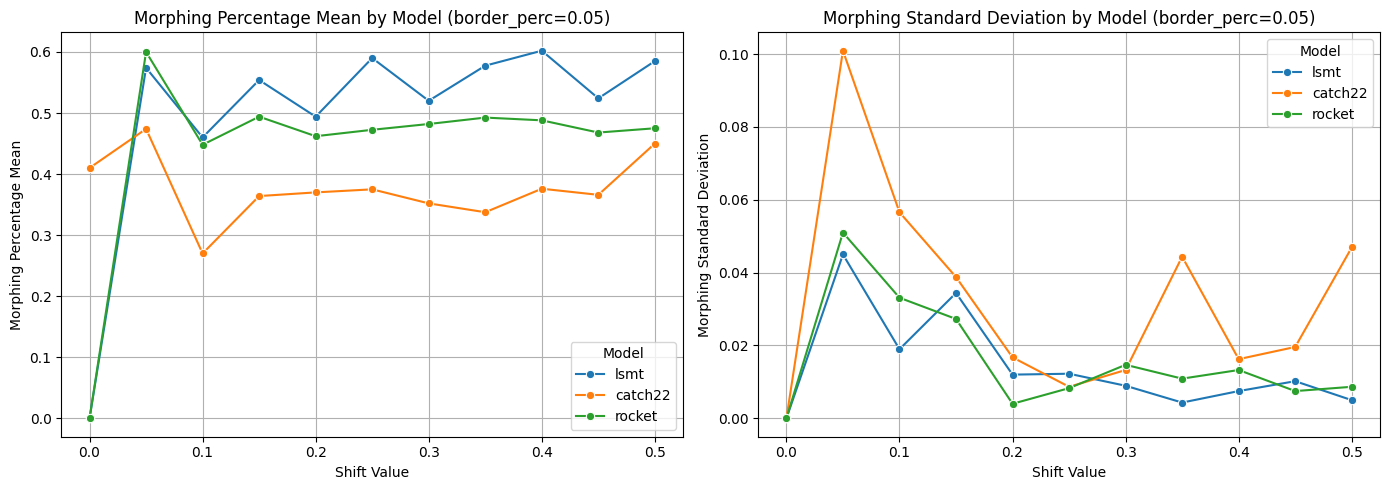

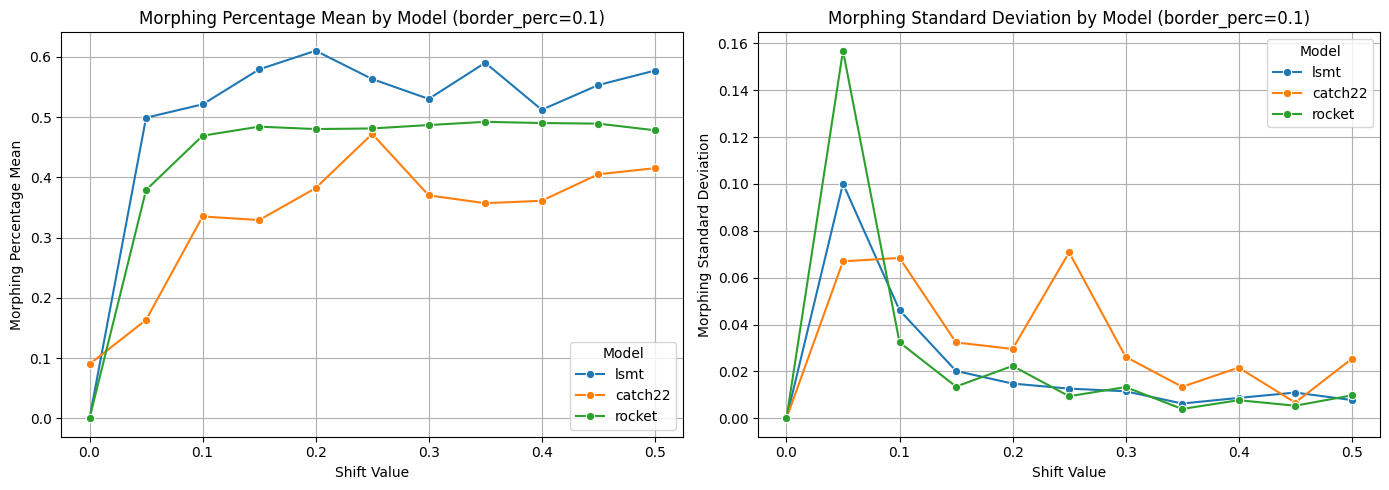

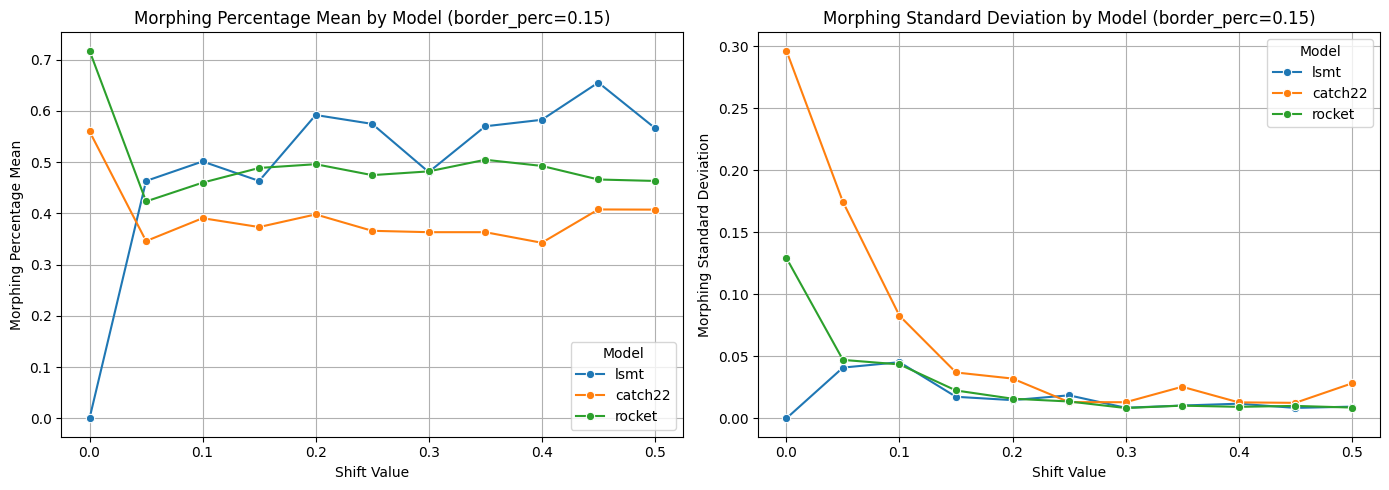

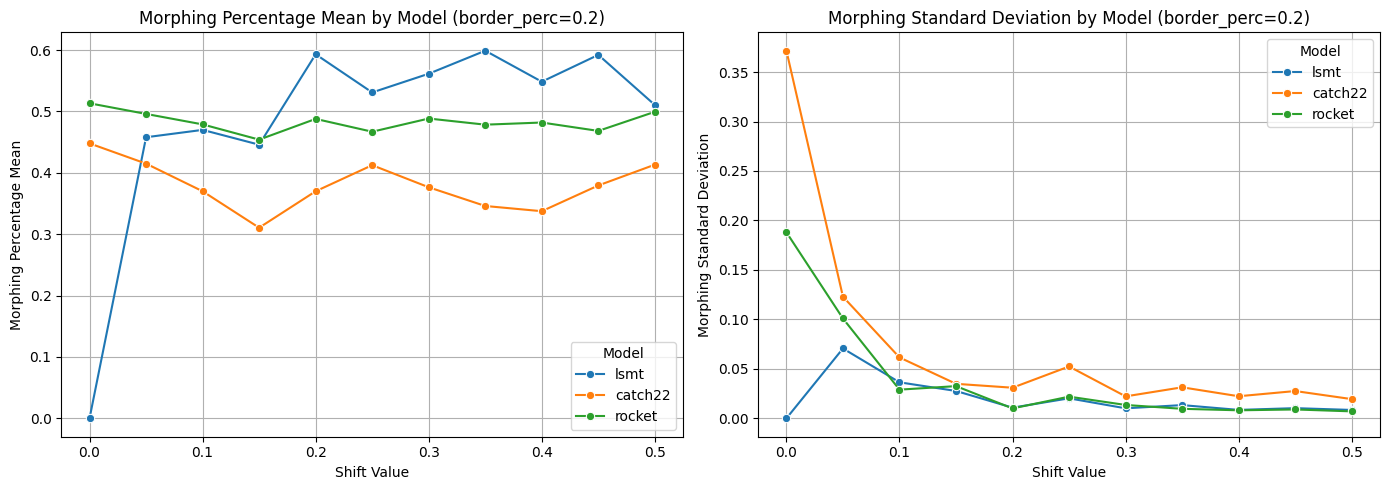

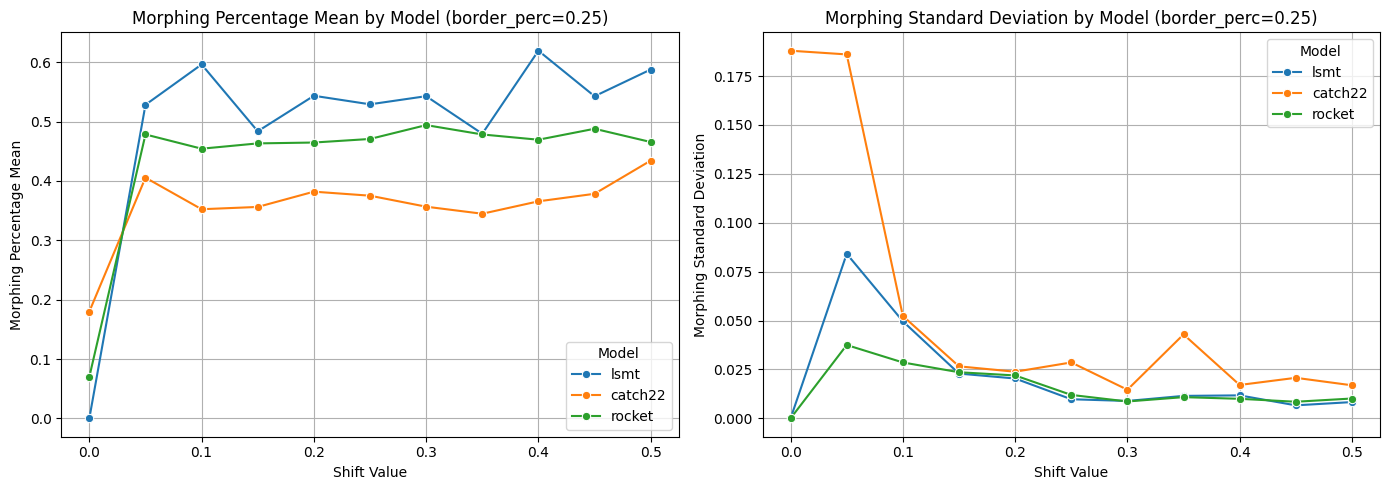

In [6]:
# Get unique border_perc values
border_perc_values = df["border_perc"].unique()

# Create plots for each border_perc level
for border_perc in border_perc_values:
    subset = df[df["border_perc"] == border_perc]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Mean Morphing Percentage
    sns.lineplot(
        data=subset, x="shift_val", y="mean", hue="model", marker="o", ax=axes[0]
    )
    axes[0].set_title(f"Morphing Percentage Mean by Model (border_perc={border_perc})")
    axes[0].set_xlabel("Shift Value")
    axes[0].set_ylabel("Morphing Percentage Mean")
    axes[0].legend(title="Model")
    axes[0].grid(True)

    # Plot Standard Deviation
    sns.lineplot(
        data=subset, x="shift_val", y="std", hue="model", marker="o", ax=axes[1]
    )
    axes[1].set_title(
        f"Morphing Standard Deviation by Model (border_perc={border_perc})"
    )
    axes[1].set_xlabel("Shift Value")
    axes[1].set_ylabel("Morphing Standard Deviation")
    axes[1].legend(title="Model")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show() 